# Simulation of a force (e.g. gravity) between Objects in 2D 

This notebook shows how to numerically simulate the movement of objects that induce a force towards each other. One prominent example for this is the gravitational force $\vec{F} = \frac{Gm_1m_2}{|r^3|}\vec{r}$ between astronomical objects like planets, stars, spaceships, etc. This notebooks is focused on said force but as the methods to solve such problems are very similar it can be easily modified to be a solution for other forces (eg. electromagnetic, van der Waals (lennard-jones potential), strong nuclear force (yukawa potential)) as well.
Therefore, an interested reader of this notebook should focus more on the methods presented here and less on the names and values of variables as they are somewhat arbitrary chosen to create a nice looking solution.   

The used language here is Julia due to its simplicity and speed.  



####  Underlying logic
What we are doing here is essentially to solve the equations of motion of N point like particles: 

$\vec{X_i}(t) = \vec{X_i}(0) +\vec{v}_i(t)t+\frac{1}{2}\vec{a}_i(t)t^2$

where

$\vec{a}_i(t) = \sum ^{N}_{j , j\neq i}\left(Gm_j \frac{\vec{X_j(t)}-\vec{X_i(t)}}{(\vec{X_j(t)}-\vec{X_i(t)})^3} \right ) $

the acceleration   $a_i(t) $  is the sum of all gravitational interactions with the other particles.  

One possible solution is to discretize the movement equation with the euler method into two iterative calculatable squences, one for the position and one for the velocity. And to calculate the coresponding new acceleration in between.

(1)

$\vec X_i(t+\Delta t) = \vec X_i(t)+ \vec v_i(t) \Delta t+\frac{1}{2} \vec a_i(t) \Delta t^2$        

(2)

$\vec{a}_i(t+\Delta t) = \sum ^{N}_{j, j\neq i}\left(Gm_j \frac{\vec{X_j(t+\Delta t)}-\vec{X_i(t+\Delta t)}}{(\vec{X_j(t+\Delta t)}-\vec{X_i(t+\Delta t)})^3} \right ) $         

(3)
 
$\vec v_i(t+\Delta t) = \vec v_i(t) + \frac{1}{2} (\vec a_i(t+\Delta t)+\vec a_i(t))\Delta t$       


#### 1. Import neccesary packages 

In [27]:
import Random as r
using Plots
#pyplot()
gr()
using Distributions
using LinearAlgebra

#### 2. Create abstractions
Firstly define a struct that represents the objects (in this case planets) which inclues all their starting parameters. Following that a function is defined that creates and adds planets to an array. The second function creates into sole arrays for position and velocity based on the planet array which is used for the calculations. The third function creates and  initalizes the accelaration list to zero. 

In [28]:
struct planet
    mass::Float64
    x::Float64
    y::Float64
    v_x::Float64
    v_y::Float64
end

function add_planet!(Planet_list::Vector{Any},Dim::Int64,Mass::Float64,x,y,v_x,v_y)
    push!(Planet_list, planet(Mass,x,y,v_x,v_y))
end

function create_pos_vel_lists(Planet_list::Vector{Any})
    X_pos =[[i.x for i in Planet_list]]
    Y_pos =[[i.y for i in Planet_list]]
    X_vel =[[i.v_x for i in Planet_list]]
    Y_vel =[[i.v_y for i in Planet_list]]

    return X_pos, Y_pos, X_vel, Y_vel 
end

function create_acel_lists(Planet_list::Vector{Any})
    X_a  = [i = 0.0 for i in planet_list]
    Y_a = [i = 0.0 for i in planet_list]
    X_a_old = deepcopy(X_a)
    Y_a_old = deepcopy(Y_a)
    
    return X_a, Y_a, X_a_old, Y_a_old
end

;

Create position and velocity lists where of planet list provides start configuration

In [29]:
function create_pos_vel_acel_lists(Planet_list::Vector{Any})
    X_pos =[[i.x for i in Planet_list]]
    Y_pos =[[i.y for i in Planet_list]]
    X_vel =[[i.v_x for i in Planet_list]]
    Y_vel =[[i.v_y for i in Planet_list]]
    X_a  = [i = 0.0 for i in planet_list]
    Y_a = [i = 0.0 for i in planet_list]
    X_a_old = deepcopy(X_a)
    Y_a_old = deepcopy(Y_a)
    
    return X_pos, Y_pos, X_vel, Y_vel, X_a, Y_a, X_a_old, Y_a_old
end

x_pos, y_pos, x_vel, y_vel, x_a, y_a, x_a_old, y_a_old = create_pos_vel_acel_lists(planet_list);

#### 3.Translate the equations into code
##### 3.1 Calculate acceleration
The first thing to do is to calculate the initial acceleration of the objects in the first timestep. Therefore we have to calculate equation (2) first. For that we need the pairwise distance ($\vec{X_j(t)}-\vec{X_i(t)}$) of all objects. The following function does exactly that by iteration over the objects in two loops and stores the results elegantly in a distance matrix. This operation scales quadraticaly ($\thicksim N^2$)  with particle number and is the main driver of computation time for big systems with many objects.  

The second function calcultes equation (2) for all particles with the help of the previously created distance matrix. As we also need the acceleration of the previous time step in equation (3), the old acceleration is stored and not discared.    

In [30]:
function create_dist_matrix(X_pos::Vector{Vector{Float64}}, Y_pos::Vector{Vector{Float64}})
    Number_planets = length(X_pos[1])
    t = length(X_pos)
    # intitalize array of vectors
    Dist_matrix =Array{Vector{Float64},2}(undef,Number_planets,Number_planets)
    for i =1:Number_planets
        for j = 1:Number_planets
            Dist_matrix[i,j] = [0.0,0.0]
        end
    end
    #fill dist_matrix
    planet_iterator = 1
    for i = 1:Number_planets
        planet_iterator += 1
        for j = planet_iterator:Number_planets
            #calculate the distance of planets 
            #the used convention is that dist_matrix[1,2] gives the vector pointing form planet 1 to planet 2 (r2-r1)
            Dist_matrix[i,j][1] = X_pos[t][j]-X_pos[t][i]
            Dist_matrix[i,j][2] = Y_pos[t][j]-Y_pos[t][i]
            #dist_matrix is symetrical, therefore
            Dist_matrix[j,i] = Dist_matrix[i,j].* -1
            #println(Dist_matrix)
        end
    end
    return Dist_matrix
end

function calculate_gravity_accelaeration!(Planet_list::Vector{Any},X_pos::Vector{Vector{Float64}}, Y_pos::Vector{Vector{Float64}},
        X_a::Vector{Float64}, Y_a::Vector{Float64},X_a_old::Vector{Float64}, Y_a_old::Vector{Float64},G)
    
    Number_planets = length(X_a)
    t = length(X_pos)
    #create matrix that contains all planetary distances
    Dist_matrix = create_dist_matrix(X_pos,Y_pos)
    #save previous accelatartion vector in _a_old for weighted velocity calculation later
    X_a_old = deepcopy(X_a)
    Y_a_old = deepcopy(Y_a)
    #set previous accelaration vector to zero
    X_a .= 0.0 
    Y_a .= 0.0 
    #println(X_a,Y_a)
    #temporay accelatration vector for each particle
    a =[0.0,0.0]
    for i = 1:Number_planets
        for j = 1:Number_planets
            if j == i
                continue
            end   
            a= (Dist_matrix[i,j]/norm(Dist_matrix[i,j]))*G*Planet_list[j].mass*1/(norm(Dist_matrix[i,j])^2)
            X_a[i] += a[1]
            Y_a[i] += a[2]
        end
    end
end
;

##### 3.2 Update positions
This function is just equation (1) written into code. It calculates the new position based on the previous position, velocity and accelaration and extends the position arrays by one position. 



In [31]:
function update_position!(X_pos::Vector{Vector{Float64}}, Y_pos::Vector{Vector{Float64}},X_vel::Vector{Vector{Float64}}, Y_vel::Vector{Vector{Float64}},
        X_a::Vector{Float64}, Y_a::Vector{Float64},Δt::Float64,Timesteps::Int64,Dim::Int64)
    
    Number_planets = length(X_a)
    #calculalte the velocity and position change for every planet
    t = length(X_pos)
    #initialize new x and y pos 
    push!(X_pos, zeros(Number_planets))
    push!(Y_pos, zeros(Number_planets))

    #update Positions
    for i = 1:Number_planets
        
        #update positions follwing euler method
        X_pos[t+1][i] = X_pos[t][i] +X_vel[t][i]*Δt+1/2*X_a[i]*Δt^2
        Y_pos[t+1][i] = Y_pos[t][i] +Y_vel[t][i]*Δt+1/2*Y_a[i]*Δt^2
    end
end
;

##### 3.3 Update velocities
This function is just equation (3) written into code. It calculates the new velocity based on the previous velocity and the accelaration in the last two timesteps and extends the velcotiy arrays by one position. 

In [32]:
function update_velcotiy!(X_vel::Vector{Vector{Float64}}, Y_vel::Vector{Vector{Float64}},
        X_a::Vector{Float64}, Y_a::Vector{Float64},X_a_old::Vector{Float64}, Y_a_old::Vector{Float64},Δt::Float64,Timesteps::Int64,Dim::Int64)
    
    Number_planets = length(X_a)
    #calculalte the velocity and position change for every planet
    t = length(X_vel)
    #initialize new x and y pos & velocity
    push!(X_vel, zeros(Number_planets))
    push!(Y_vel, zeros(Number_planets))

    #update Positions
    for i = 1:Number_planets
        
        #update positions follwing euler method
        X_vel[t+1][i] = X_vel[t][i] + (1/2)*(X_a[i]+X_a_old[i])*Δt
        Y_vel[t+1][i] = Y_vel[t][i] + (1/2)*(Y_a[i]+Y_a_old[i])*Δt
    end
end
;

#### 4. Initialize system
##### 4.1 Define Constants
All the following variables do not change during a simulation run.



In [58]:
G = 10.0           # G is the scaling factor for the strenght of the attractive force
Δt = 0.001         # discretisation presicion of the numerical solution 
timesteps = 200    # Simulation duration
dim = 120          # Size of the viewable simulation space 
planet_list =[];   # Empty array which will contain the objects in the system


##### 4.2 Create Objects 
In this step an exemplary system with 2 bodys is created. The first body is a 10000 times heavier than the others which resembles the mass relation of earth like planets towards a sun like star. The velocities are also choosen in a way, that the ligther bodies are gravitational bound to the first and rotating around it. 

After that the position, velocity and accelaration arrays are created. And the first inital accelaration is calculated. 

In [59]:
# create objects 
add_planet!(planet_list,dim,10000.0,0,0,0,0)    # star
#add_planet!(planet_list,dim,1.0,0,25,51.0,0)   # planet 
add_planet!(planet_list,dim,1.0,0,50,33.0,0)    # planet  
add_planet!(planet_list,dim,1.0,0,100,22.8,0)   # planet  


x_pos, y_pos, x_vel, y_vel = create_pos_vel_lists(planet_list)
x_a, y_a, x_a_old, y_a_old = create_acel_lists(planet_list)

calculate_gravity_accelaeration!(planet_list,x_pos, y_pos, x_a, y_a, x_a_old , y_a_old, G)


##### 5. Visualize starting configuration 
In this step the starting positions of the objects is plotted with the "Plots" package (https://docs.juliaplots.org/latest/tutorial/). 

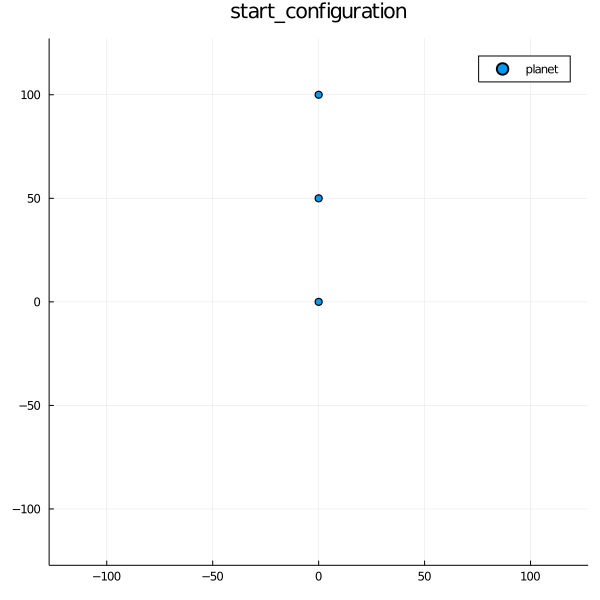

In [60]:
plot(
    x_pos[1],
    y_pos[1], 
    seriestype = :scatter,
    title = "start_configuration",
    xlim = [-dim,dim], 
    ylim = [-dim,dim],
    #markersize = 1,
    size = (600,600),
    label ="planet"
    )

##### 6. Simulate the system
Here ist the actual simulation of the system is happening. First the number of simulation steps is calculated with the number of timesteps and the discretisation step size $\Delta t$. After that a loop over all simulation steps is calculated, where in each step the three defined functions corresponding to equations (1), (2) and (3) are calculated.     

In [61]:
simulation_steps = Int((1/Δt)*timesteps)
for i = 1:simulation_steps
    update_position!(x_pos,y_pos,x_vel,y_vel,x_a,y_a,Δt,timesteps,dim)
    calculate_gravity_accelaeration!(planet_list,x_pos, y_pos, x_a, y_a, x_a_old , y_a_old, G)
    update_velcotiy!(x_vel, y_vel,x_a,y_a,x_a_old, y_a_old,Δt,timesteps,dim)
end


##### 7. Visualize system evolution 
In the last and final step an animation is created wich shows the position of the objects over time. The "Plots" packages is used again here. For our specifically chosen example of stars and planets, we see that the planets orbit the central star on elliptical orbits as in our real solar system. 

 79.826177 seconds (421.35 M allocations: 8.013 GiB, 1.61% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\ank10ki\Dropbox\phd\Julia_test\First_trys\2_planets_200_timesteps_big.gif
└ @ Plots C:\Users\ank10ki\.julia\packages\Plots\Awg62\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\ank10ki\\Dropbox\\phd\\Julia_test\\First_trys\\2_planets_200_timesteps_big.gif")
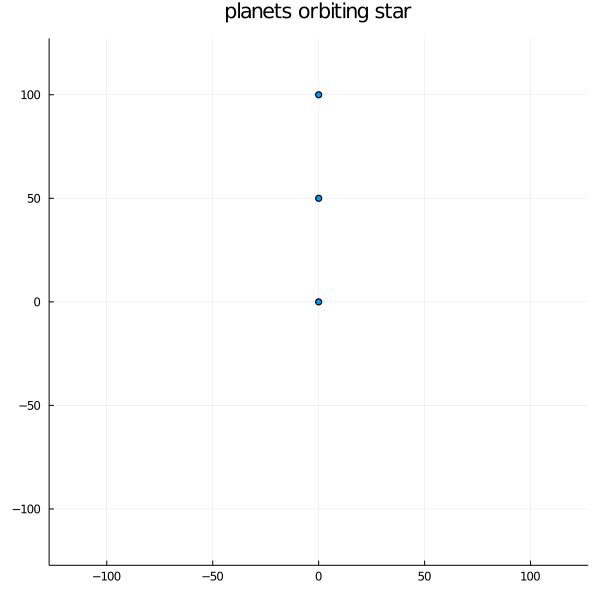

In [62]:
@time begin
    anim = @animate for j = 1:100:length(x_pos)   # animate only every 100th frame, to save computation time
         plot(
            x_pos[j],
            y_pos[j], 
            seriestype = :scatter,
            title = ("planets orbiting star"),
            legend=false,
            xlim = [-dim,dim], 
            ylim = [-dim,dim],
            #ylim = [-dim-5,dim+5],
            #markersize = 1,
            size = (600,600),
            label ="planet"
            )
    end
    gif(anim,(string(2)* "_planets_" *string(timesteps)*"_timesteps_big.gif"), fps = 60) 
    # .gif in file name can be changed to .mp4 or .mov to create movie instead of gif 
end

##### 8. Play around
Here we are doing to same as before, with the exception that the masses, velocities and positions of the objects are randomly chosen. 
Expect from some special cases, systems with more than 2 bodies show a chaotic behaviour, even though the defining equations are fully deterministic (see https://en.wikipedia.org/wiki/Butterfly_effect , https://en.wikipedia.org/wiki/Three-body_problem).
The $N^2$ scaling of the computation time with planet number can be seen here for big systems.  

In [38]:
G = 10.0           # G is the scaling factor for the strenght of the attractive force
Δt = 0.001         # discretisation presicion of the numerical solution 
timesteps = 10    # Simulation duration
dim = 500          # Size of the viewable simulation space 
planet_list =[];   # Empty array which will contain the objects in the system

planet_number = 20
for i = 1:planet_number
    add_planet!(planet_list,dim,rand(Normal(1,100)),rand(Normal(0,50)),rand(Normal(0,50)),rand(Normal(0,50)),rand(Normal(0,50)))
end
   

In [39]:
x_pos, y_pos, x_vel, y_vel = create_pos_vel_lists(planet_list)
x_a, y_a, x_a_old, y_a_old = create_acel_lists(planet_list)

calculate_gravity_accelaeration!(planet_list,x_pos, y_pos, x_a, y_a, x_a_old , y_a_old, G)

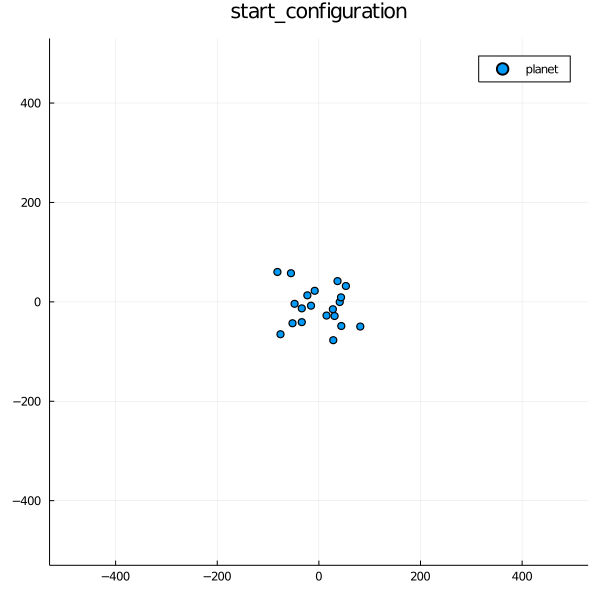

In [40]:
plot(
    x_pos[1],
    y_pos[1], 
    seriestype = :scatter,
    title = "start_configuration",
    xlim = [-dim,dim], 
    ylim = [-dim,dim],
    #markersize = 1,
    size = (600,600),
    label ="planet"
    )

In [41]:
simulation_steps = Int((1/Δt)*timesteps)
for i = 1:simulation_steps
    update_position!(x_pos,y_pos,x_vel,y_vel,x_a,y_a,Δt,timesteps,dim)
    calculate_gravity_accelaeration!(planet_list,x_pos, y_pos, x_a, y_a, x_a_old , y_a_old, G)
    update_velcotiy!(x_vel, y_vel,x_a,y_a,x_a_old, y_a_old,Δt,timesteps,dim)
end


  4.413553 seconds (25.09 M allocations: 483.928 MiB, 1.41% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\ank10ki\Dropbox\phd\Julia_test\First_trys\2_planets_10_timesteps_big.gif
└ @ Plots C:\Users\ank10ki\.julia\packages\Plots\Awg62\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\ank10ki\\Dropbox\\phd\\Julia_test\\First_trys\\2_planets_10_timesteps_big.gif")
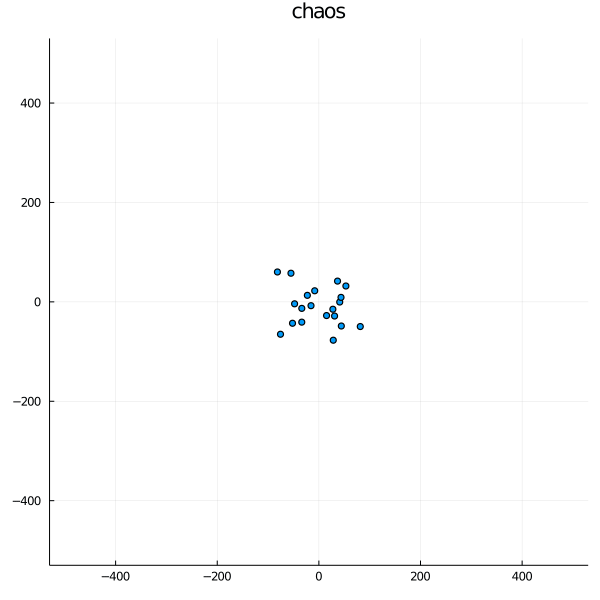

In [42]:
@time begin
    anim = @animate for j = 1:100:length(x_pos)
         plot(
            x_pos[j],
            y_pos[j], 
            seriestype = :scatter,
            title = ("chaos"),
            legend=false,
            xlim = [-dim,dim], 
            ylim = [-dim,dim],
            #ylim = [-dim-5,dim+5],
            #markersize = 1,
            size = (600,600),
            label ="planet"
            )
    end
    gif(anim,(string(2)* "_planets_" *string(timesteps)*"_timesteps_big.gif"), fps = 60) 
    # .gif in file name can be changed to .mp4 or .mov to create movie instead of gif 
end